In [1]:
!mkdir /content/processeddata
!git clone https://github.com/zezhishao/STEP
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html
%cd /content/STEP
!pip install -r requirements.txt
%cd /content
from IPython.display import clear_output
clear_output()

# **MHealth Dataset**

The MHEALTH (Mobile HEALTH) dataset comprises body motion and vital signs recordings for 10 volunteers of diverse profile while performing several physical activities. Sensors placed on the subject's chest, right wrist and left ankle are used to measure the motion experienced by diverse body parts, namely, acceleration, rate of turn and magnetic field orientation. The sensor positioned on the chest also provides 2-lead ECG measurements, which can be potentially used for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG. All sensing modalities are recorded at a sampling rate of 50 Hz.


---

Prune to select:
* 3 participants
* Vars: 
  * Column 1: acceleration from the chest sensor (X axis)
  * Column 2: acceleration from the chest sensor (Y axis)
  * Column 3: acceleration from the chest sensor (Z axis)
  * Column 4: electrocardiogram signal (lead 1)
  * Column 5: electrocardiogram signal (lead 2)
  * Column 6: acceleration from the left-ankle sensor (X axis)
  * Column 9: gyro from the left-ankle sensor (X axis)

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip
!unzip MHEALTHDATASET.zip
from IPython.display import clear_output
clear_output()
import os, torch 
import pandas as pd
import numpy as np
mhealth_dataset = []
for path, dir, file in os.walk("/content/MHEALTHDATASET"):
    for fileNames in file:
        if fileNames.endswith("log"):
            fileName = str(os.path.join(path,fileNames))
            tmpData = pd.read_csv(fileName, sep='\t', engine='python')
            np.shape(tmpData.to_numpy()) # time x variables
            mhealth_dataset.append(tmpData.to_numpy())

We will use participants to represent the "sensors" in the traffic dataset, because the features/variables are collected from all participants.

In [3]:
tcat = []
for i in range(len(mhealth_dataset)):
  # Truncate all time series to the same length
  t = torch.from_numpy(mhealth_dataset[i][:18303,:])
  tcat.append(t)
tcat = torch.stack(tcat, dim=0)
tcat.size() # subjects x time x var
mhealth = tcat.numpy()
print("Raw 3D time series shape: {0}".format(mhealth.shape))
mhealth_reshaped = np.transpose(mhealth, (1, 0, 2))
print("New 3D time series shape: {0}".format(mhealth_reshaped.shape))

# Downsample the data
mhealth_reshaped_ds = mhealth_reshaped[::5]
print("Downsampled 3D time series shape: {0}".format(mhealth_reshaped_ds.shape))

Raw 3D time series shape: (10, 18303, 24)
New 3D time series shape: (18303, 10, 24)
Downsampled 3D time series shape: (3661, 10, 24)


In [4]:
# Truncate the dataset
nsubjects = 2
features_to_keep = [1,2,5,6,9]
truncated_mhealth = mhealth_reshaped_ds[:, :nsubjects, features_to_keep]
print("Truncated time series shape: {0}".format(truncated_mhealth.shape)) # timesteps x features

Truncated time series shape: (3661, 2, 5)


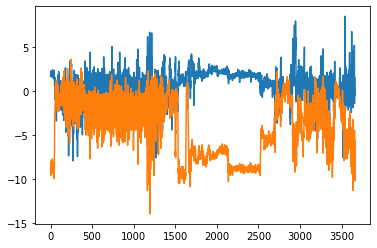

In [5]:
# Plot
!pip install Pillow==9.0.0
clear_output()
import matplotlib.pyplot as plt
trace = truncated_mhealth[:, 0, 0] # subject 1, feature 1
trace2 = truncated_mhealth[:, 0, 1] # subject 1, feature 2
plt.plot(trace)
plt.plot(trace2)

## Format MHealth data for STEP

Generates pickle files

In [6]:
from easytorch.utils.registry import Registry

SCALER_REGISTRY = Registry("Scaler")
@SCALER_REGISTRY.register()
def standard_transform(data: np.array, output_dir: str, name: str, train_index: list, 
                       history_seq_len: int, future_seq_len: int, norm_each_channel: int = False) -> np.array:
    """Standard normalization.
    Args:
        data (np.array): raw time series data.
        output_dir (str): output dir path.
        train_index (list): train index.
        history_seq_len (int): historical sequence length.
        future_seq_len (int): future sequence length.
        norm_each_channel (bool): whether to normalization each channel.
    Returns:
        np.array: normalized raw time series data.
    """

    # data: L, N, C, C=1; time x sensors x features
    data_train = data[:train_index[-1][1], ...]
    if norm_each_channel:
        mean, std = data_train.mean(axis=0, keepdims=True), data_train.std(axis=0, keepdims=True)
    else:
        mean, std = data_train[..., 0].mean(), data_train[..., 0].std()

    print("mean (training data):", mean)
    print("std (training data):", std)
    scaler = {}
    scaler["func"] = re_standard_transform.__name__
    scaler["args"] = {"mean": mean, "std": std}
    # label to identify the scaler for different settings.
    with open(output_dir + "/" + "scaler_in{0}_out{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
        pickle.dump(scaler, f)

    def normalize(x):
        return (x - mean) / std

    data_norm = normalize(data)
    return data_norm
@SCALER_REGISTRY.register()
def re_standard_transform(data: torch.Tensor, **kwargs) -> torch.Tensor:
    """Standard re-transformation.

    Args:
        data (torch.Tensor): input data.

    Returns:
        torch.Tensor: re-scaled data.
    """

    mean, std = kwargs["mean"], kwargs["std"]
    if isinstance(mean, np.ndarray):
        mean = torch.from_numpy(mean).type_as(data).to(data.device).unsqueeze(0)
        std = torch.from_numpy(std).type_as(data).to(data.device).unsqueeze(0)
    data = data * std
    data = data + mean
    return data

In [7]:
%cd /content/STEP
import os
import sys
import shutil
import pickle
import argparse
import numpy as np
import torch

# Set up parameters
history_seq_len = 50
future_seq_len = 50
train_ratio = 0.6
valid_ratio = 0.2
output_dir = '/content/processeddata'
name = 'truncated_mhealth'

t, n, f = truncated_mhealth.shape
num_samples = t - (history_seq_len + future_seq_len) + 1
train_num_short = round(num_samples * train_ratio)
valid_num_short = round(num_samples * valid_ratio)
test_num_short = round(num_samples * (1 - train_ratio - valid_ratio))
print("number of training samples:{0}".format(train_num_short))
print("number of validation samples:{0}".format(valid_num_short))
print("number of test samples:{0}".format(test_num_short))

# Get indices
index_list = []
for t in range(history_seq_len, num_samples + history_seq_len):
    index = (t-history_seq_len, t, t+future_seq_len)
    index_list.append(index)

train_index = index_list[:train_num_short]
valid_index = index_list[train_num_short: train_num_short + valid_num_short]
test_index = index_list[train_num_short +
                        valid_num_short: train_num_short + valid_num_short + test_num_short]

# Normalize the data
scaler = standard_transform
data_norm = scaler(truncated_mhealth, output_dir, name, train_index, history_seq_len, future_seq_len)
feature_list = [data_norm]
processed_data = np.concatenate(feature_list, axis=-1)
print("Processed series shape: {0}".format(processed_data.shape))

# Write data to pkl file
index = {}
index["train"] = train_index
index["valid"] = valid_index
index["test"] = test_index
with open(output_dir + "/" +"index_in{0}_out{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(index, f)

data = {}
data["processed_data"] = processed_data
with open(output_dir + "/" + "data_in{0}_out{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(data, f)

print('')
print('Truncated MHealth data for STEP written to pkl file in output dir (no adj matrix)')

/content/STEP
number of training samples:2137
number of validation samples:712
number of test samples:712
mean (training data): -0.12756519325096066
std (training data): 1.507568504329547
Processed series shape: (3661, 2, 5)

Truncated MHealth data for STEP written to pkl file in output dir (no adj matrix)


In [27]:
##Create a folder /content/STEP/datasets/mHealth
## move data files to te folder
## under /content/STEP/step/step_arch update discrete_graph_learning.py
## under /content/STEP/step upload TSFormer_mHealth.py
## under /content/STEP/basicts/runners update base_tsf_runner.py
!python step/run.py --cfg='step/TSFormer_mHealth.py'

2023-03-14 17:06:13,699 - easytorch-launcher - INFO - Launching EasyTorch training.
DESCRIPTION: TSFormer(mHealth) configuration
RUNNER: <class 'step.step_runner.tsformer_runner.TSFormerRunner'>
DATASET_CLS: <class 'basicts.data.dataset.TimeSeriesForecastingDataset'>
DATASET_NAME: mHealth
DATASET_TYPE: mHealth
DATASET_INPUT_LEN: 50
DATASET_OUTPUT_LEN: 50
GPU_NUM: 0
ENV:
  SEED: 0
  CUDNN:
    ENABLED: True
MODEL:
  NAME: TSFormer
  ARCH: <class 'step.step_arch.tsformer.tsformer.TSFormer'>
  PARAM:
    patch_size: 50
    in_channel: 1
    embed_dim: 96
    num_heads: 4
    mlp_ratio: 4
    dropout: 0.1
    num_token: 1
    mask_ratio: 0.75
    encoder_depth: 4
    decoder_depth: 1
    mode: pre-train
  FORWARD_FEATURES: [0]
  TARGET_FEATURES: [0]
TRAIN:
  LOSS: masked_mae
  OPTIM:
    TYPE: Adam
    PARAM:
      lr: 0.0005
      weight_decay: 0
      eps: 1e-08
      betas: [0.9, 0.95]
  LR_SCHEDULER:
    TYPE: MultiStepLR
    PARAM:
      milestones: [50]
      gamma: 0.5
  CLIP_GRAD_P

In [28]:
!cp /content/STEP/checkpoints/TSFormer_100/2571bc8a423a2de2b0aef1a39b252b43/TSFormer_best_val_MAE.pt tsformer_ckpt/TSFormer_mHealth.pt

In [10]:
## add code to it to save loss to new file
!python step/run.py --cfg='step/STEP_mHealth.py' --gpus='0'

2023-03-14 22:57:55,373 - easytorch-launcher - INFO - Launching EasyTorch training.
DESCRIPTION: STEP(mHealth) configuration
RUNNER: <class 'step.step_runner.step_runner.STEPRunner'>
DATASET_CLS: <class 'step.step_data.forecasting_dataset.ForecastingDataset'>
DATASET_NAME: mHealth
DATASET_TYPE: mHealth
DATASET_INPUT_LEN: 50
DATASET_OUTPUT_LEN: 50
DATASET_ARGS:
  seq_len: 50
GPU_NUM: 1
ENV:
  SEED: 0
  CUDNN:
    ENABLED: True
MODEL:
  NAME: STEP
  ARCH: <class 'step.step_arch.step.STEP'>
  PARAM:
    dataset_name: mHealth
    pre_trained_tsformer_path: tsformer_ckpt/TSFormer_mHealth.pt
    tsformer_args:
      patch_size: 50
      in_channel: 1
      embed_dim: 96
      num_heads: 4
      mlp_ratio: 4
      dropout: 0.1
      num_token: 50
      mask_ratio: 0.75
      encoder_depth: 4
      decoder_depth: 1
      mode: forecasting
    backend_args:
      num_nodes: 2
      supports: tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)
      dropout: 0.3
      gcn_bool: True
      

In [55]:
!python test/test_inference.py

2023-03-14 23:55:09,110 - easytorch-launcher - INFO - Launching EasyTorch runner.
DESCRIPTION: STEP(mHealth) configuration
RUNNER: <class 'step.step_runner.step_runner.STEPRunner'>
DATASET_CLS: <class 'step.step_data.forecasting_dataset.ForecastingDataset'>
DATASET_NAME: mHealth
DATASET_TYPE: mHealth
DATASET_INPUT_LEN: 50
DATASET_OUTPUT_LEN: 50
DATASET_ARGS:
  seq_len: 50
GPU_NUM: 1
ENV:
  SEED: 0
  CUDNN:
    ENABLED: True
MODEL:
  NAME: STEP
  ARCH: <class 'step.step_arch.step.STEP'>
  PARAM:
    dataset_name: mHealth
    pre_trained_tsformer_path: tsformer_ckpt/TSFormer_mHealth.pt
    tsformer_args:
      patch_size: 50
      in_channel: 1
      embed_dim: 96
      num_heads: 4
      mlp_ratio: 4
      dropout: 0.1
      num_token: 50
      mask_ratio: 0.75
      encoder_depth: 4
      decoder_depth: 1
      mode: forecasting
    backend_args:
      num_nodes: 2
      supports: tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)
      dropout: 0.3
      gcn_bool: True
      ad

    1.173400044441223145e+00
0                   1.698100
1                   2.652800
2                   0.768970
3                   1.660800
4                  -0.520860
5                  -2.394700
6                  -1.414400
7                  -2.455700
8                  -0.897290
9                   0.893770
10                  2.175000
11                  2.642800
12                  4.631299
13                  5.682900
14                  5.951000
15                  4.834500
16                  4.559600
17                  4.952899
18                  4.597900
19                  3.769700
20                  4.498400
21                  3.843200
22                  3.559300
23                  1.964100
24                  1.459300
25                  0.565830
26                  1.855700
27                  2.114500
28                  3.067400
29                  3.415100
30                  4.419500
31                  5.990500
32                  6.112000
33            

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

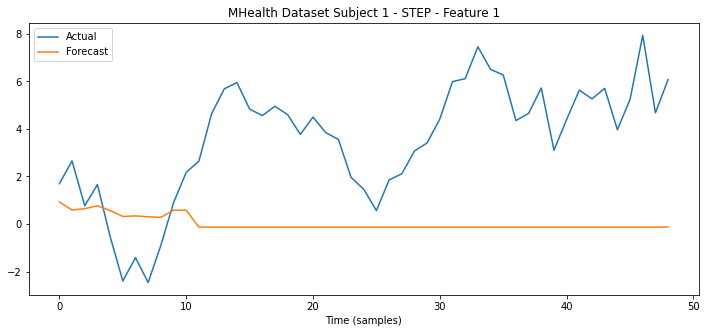

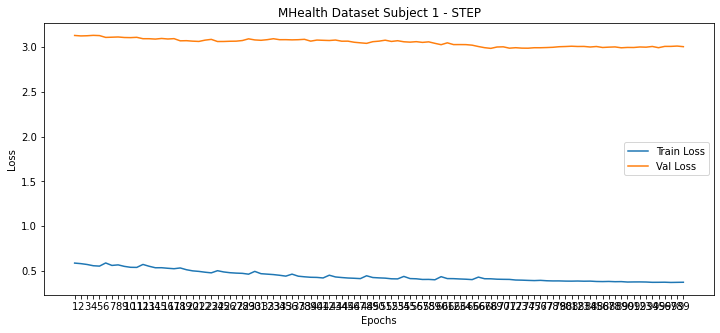

In [72]:
# Here is some code to generate your predicted time series figures (see GCN section below)
# Please use the same format, but replace <GCN> with <STEP> or <GraphWaveNet>
# Note: Subject 1 for MHealth, Subject 10 for MSense
# Upload figures to an image hosting website and embed the images in Markdown
import pandas as pd
mh_y= pd.read_csv('real.csv')
mh_y_pred = pd.read_csv('label.csv')
print(my_h)
mh_y = mh_y.to_numpy()
mh_y_pred = mh_y_pred.to_numpy()
import matplotlib.pyplot as plt
from google.colab import files
plt.figure(figsize=(12, 5))
plt.plot(mh_y)
plt.plot(mh_y_pred)
plt.legend(["Actual", "Forecast"])
plt.xlabel('Time (samples)')
plt.title(r"MHealth Dataset Subject 1 - STEP - Feature 1" )
          #+ '\n' + \          
          #r"Naive MAE: %1.3f" %naive_mae + r" , " r"Model MAE: %1.3f" %model_mae, \
          #wrap=True, multialignment='center')
plt.savefig('mhealth_subject1_predictedfeature1_STEP.png', bbox_inches='tight')
files.download('mhealth_subject1_predictedfeature1_STEP.png') 
msfit = pd.read_csv('mHealth.csv')
msfit = msfit.to_numpy()
# Example code to plot losses
plt.figure(figsize=(12, 5))
plt.plot(msfit[:,0])
plt.plot(msfit[:,1])
plt.legend(["Train Loss", "Val Loss"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(len(msfit)), 
           np.arange(1, len(msfit)+1))
plt.title(r"MHealth Dataset Subject 1 - STEP")
plt.savefig('mhealth_subject1_lossoverepochs_STEP.png', bbox_inches='tight')
files.download('mhealth_subject1_lossoverepochs_STEP.png') 

# **MotionSense Dataset**

This dataset includes time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). It is collected with an iPhone 6s kept in the participant's front pocket using SensingKit which collects information from Core Motion framework on iOS devices. All data collected in 50Hz sample rate. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. With this dataset, we aim to look for personal attributes fingerprints in time-series of sensor data, i.e. attribute-specific patterns that can be used to infer gender or personality of the data subjects in addition to their activities.

---
Prune to select:
* 3 participants
* Walk & jog data only
* Vars: acceleration (x,y,z); rotation (x,y,z); gravity (x;y;z)


In [11]:
%cd /content/
!git clone https://github.com/mmalekzadeh/motion-sense
!unzip /content/motion-sense/data/A_DeviceMotion_data.zip
!unzip /content/motion-sense/data/B_Accelerometer_data.zip
!unzip /content/motion-sense/data/C_Gyroscope_data.zip
clear_output()

In [12]:
sub_ids = [9,10]

def get_ds_infos():
    """ Gets inforamtion about data subjects' attributes""" 
    dss = pd.read_csv("/content/motion-sense/data/data_subjects_info.csv")
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """ Select the sensors and the mode to shape the final dataset. """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list

def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=False):
    """ It returns a time-series of sensor data. """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0, num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0, num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in sub_ids:
        for act_id, act in enumerate(act_labels): # for each activity
            for trial in trial_codes[act_id]: # for each variable
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset, vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

# Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
# attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration",'gravity','rotationRate']
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS[2:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))  

[INFO] -- Selected sensor data types: ['userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['wlk', 'jog']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(39731, 16)


19111


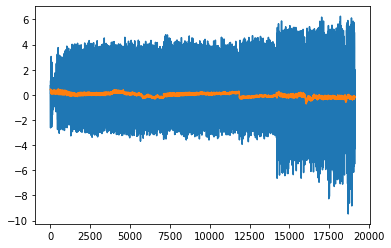

20620


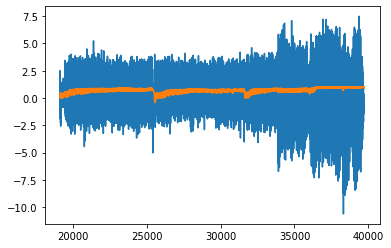

In [13]:
for sub_id in [8,9]:
  sub_dataset = dataset[dataset["id"].isin([float(sub_id)])]
  print(len(sub_dataset))
  trace = sub_dataset["gravity.x"]
  trace2 = sub_dataset["rotationRate.x"]
  plt.plot(trace2); plt.plot(trace); plt.show()

In [14]:
dataset

,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
0,-0.120483,-0.117631,0.414023,0.427459,0.863450,-0.267829,0.724147,-1.204834,1.702835,0.0,8.0,93.0,190.0,32.0,1.0,7.0
1,-0.189189,-0.202624,0.385852,0.446055,0.844942,-0.295138,0.670438,-2.108621,1.591454,0.0,8.0,93.0,190.0,32.0,1.0,7.0
2,-0.373517,-0.334173,0.445768,0.455503,0.828192,-0.326520,0.455867,-2.554562,1.408929,0.0,8.0,93.0,190.0,32.0,1.0,7.0
3,-0.460145,-0.308543,0.494584,0.457719,0.815104,-0.355103,0.045947,-2.826025,1.186360,0.0,8.0,93.0,190.0,32.0,1.0,7.0
4,-0.540022,-0.273064,0.581685,0.453826,0.807595,-0.376607,-0.447720,-2.766856,0.937145,0.0,8.0,93.0,190.0,32.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39726,0.053884,-0.138966,-0.097085,0.918955,0.321858,0.227852,-0.172824,-1.209841,0.306680,1.0,9.0,72.0,164.0,31.0,0.0,16.0
39727,0.092630,-0.099254,0.020005,0.928046,0.314906,0.198883,-0.660972,-1.645687,0.234395,1.0,9.0,72.0,164.0,31.0,0.0,16.0
39728,0.081522,0.018782,-0.045352,0.932882,0.305208,0.191227,-1.369109,-0.303478,0.324936,1.0,9.0,72.0,164.0,31.0,0.0,16.0
39729,-0.069515,0.170097,-0.053982,0.935924,0.290627,0.198925,-1.062130,0.021990,0.717633,1.0,9.0,72.0,164.0,31.0,0.0,16.0


In [66]:
truncated_msense = []
features_to_keep = [1,2,3,4,6]
for sub_id in [8,9]:
  sub_dataset = dataset[dataset["id"].isin([float(sub_id)])]
  sub_tensor = torch.tensor(sub_dataset.values)
  sub_tensor = sub_tensor[0:18303, features_to_keep]
  sub_tensor_numpy = sub_tensor.numpy()
  truncated_msense.append(sub_tensor_numpy)
  
truncated_msense = np.stack(truncated_msense, axis=1)
print("Msense data shape:" + str(truncated_msense.shape)) # timesteps x features


Msense data shape:(18303, 2, 5)


## Format MSense data for STEP

In [67]:
# Set up parameters
history_seq_len = 50
future_seq_len = 50
train_ratio = 0.6
valid_ratio = 0.2
output_dir = '/content/processeddata'
name = 'truncated_msense'

t, n, f = truncated_msense.shape
num_samples = t - (history_seq_len + future_seq_len) + 1
train_num_short = round(num_samples * train_ratio)
valid_num_short = round(num_samples * valid_ratio)
test_num_short = round(num_samples * (1 - train_ratio - valid_ratio))
print("number of training samples:{0}".format(train_num_short))
print("number of validation samples:{0}".format(valid_num_short))
print("number of test samples:{0}".format(test_num_short))

# Get indices
index_list = []
for t in range(history_seq_len, num_samples + history_seq_len):
    index = (t-history_seq_len, t, t+future_seq_len)
    index_list.append(index)

train_index = index_list[:train_num_short]
valid_index = index_list[train_num_short: train_num_short + valid_num_short]
test_index = index_list[train_num_short +
                        valid_num_short: train_num_short + valid_num_short + test_num_short]

# Normalize the data
scaler = standard_transform
data_norm = scaler(truncated_msense, output_dir, name, train_index, history_seq_len, future_seq_len)
feature_list = [data_norm]
processed_data = np.concatenate(feature_list, axis=-1)
print("Processed series shape: {0}".format(processed_data.shape))

# Write data to pkl file
index = {}
index["train"] = train_index
index["valid"] = valid_index
index["test"] = test_index
with open(output_dir + "/" + "index_in{0}_out{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(index, f)

data = {}
data["processed_data"] = processed_data
with open(output_dir + "/" +"data_in{0}_out{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(data, f)

print('')
print('Truncated MSense data for STEP written to pkl file in output dir (no adj matrix)')

number of training samples:10922
number of validation samples:3641
number of test samples:3641
mean (training data): 0.10031689472245009
std (training data): 0.4745993115081458
Processed series shape: (18303, 2, 5)

Truncated MSense data for STEP written to pkl file in output dir (no adj matrix)


In [75]:
%cd /content/STEP
!python step/run.py --cfg='step/TSFormer_motion_sense.py' --gpus='0'

Streaming output truncated to the last 5000 lines.
[]
[]
 57% 262/456 [00:02<00:01, 116.26it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 60% 274/456 [00:02<00:01, 113.80it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 63% 286/456 [00:02<00:01, 114.59it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 66% 299/456 [00:02<00:01, 117.49it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 68% 312/456 [00:02<00:01, 119.31it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 71% 326/456 [00:02<00:01, 124.24it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 75% 341/456 [00:02<00:00, 129.85it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
 78% 355/456 [00:02<00:00, 131.64it/s][]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [ ]:
!cp /content/STEP/checkpoints/TSFormer_100/54d4c92060ad5e34e4d15237997351ab/TSFormer_best_val_MAE.pt tsformer_ckpt/TSFormer_motion_sense.pt

In [69]:
%cd /content/STEP
!python step/run.py --cfg='step/STEP_motion_sense.py' --gpus='0'

/content/STEP
2023-03-15 00:04:23,186 - easytorch-launcher - INFO - Launching EasyTorch training.
DESCRIPTION: STEP(motion_sense) configuration
RUNNER: <class 'step.step_runner.step_runner.STEPRunner'>
DATASET_CLS: <class 'step.step_data.forecasting_dataset.ForecastingDataset'>
DATASET_NAME: motion_sense
DATASET_TYPE: motion_sense
DATASET_INPUT_LEN: 50
DATASET_OUTPUT_LEN: 50
DATASET_ARGS:
  seq_len: 50
GPU_NUM: 1
ENV:
  SEED: 0
  CUDNN:
    ENABLED: True
MODEL:
  NAME: STEP
  ARCH: <class 'step.step_arch.step.STEP'>
  PARAM:
    dataset_name: motion_sense
    pre_trained_tsformer_path: tsformer_ckpt/TSFormer_motion_sense.pt
    tsformer_args:
      patch_size: 50
      in_channel: 1
      embed_dim: 96
      num_heads: 4
      mlp_ratio: 4
      dropout: 0.1
      num_token: 1
      mask_ratio: 0.75
      encoder_depth: 4
      decoder_depth: 1
      mode: forecasting
    backend_args:
      num_nodes: 2
      supports: tensor([[1, 1],
        [1, 1]])
      dropout: 0.3
      gcn_bool

In [74]:
!python test/test_inference.py

2023-03-15 01:19:15,435 - easytorch-launcher - INFO - Launching EasyTorch runner.
DESCRIPTION: STEP(motion_sense) configuration
RUNNER: <class 'step.step_runner.step_runner.STEPRunner'>
DATASET_CLS: <class 'step.step_data.forecasting_dataset.ForecastingDataset'>
DATASET_NAME: motion_sense
DATASET_TYPE: motion_sense
DATASET_INPUT_LEN: 50
DATASET_OUTPUT_LEN: 50
DATASET_ARGS:
  seq_len: 50
GPU_NUM: 1
ENV:
  SEED: 0
  CUDNN:
    ENABLED: True
MODEL:
  NAME: STEP
  ARCH: <class 'step.step_arch.step.STEP'>
  PARAM:
    dataset_name: motion_sense
    pre_trained_tsformer_path: tsformer_ckpt/TSFormer_motion_sense.pt
    tsformer_args:
      patch_size: 50
      in_channel: 1
      embed_dim: 96
      num_heads: 4
      mlp_ratio: 4
      dropout: 0.1
      num_token: 1
      mask_ratio: 0.75
      encoder_depth: 4
      decoder_depth: 1
      mode: forecasting
    backend_args:
      num_nodes: 2
      supports: tensor([[1, 1],
        [1, 1]])
      dropout: 0.3
      gcn_bool: True
      add

    1.088493943214416504e+00
0                  -0.871810
1                  -1.412143
2                  -1.398448
3                  -1.192148
4                  -1.420252
5                  -1.254955
6                  -0.263047
7                  -0.441048
8                  -0.008639
9                   1.425073
10                  4.516730
11                  2.452659
12                  1.634715
13                  1.541744
14                  0.344696
15                 -0.133910
16                 -0.647754
17                 -1.027335
18                 -1.467660
19                 -1.864339
20                 -2.112090
21                 -1.615230
22                 -0.943397
23                 -0.546979
24                  0.584820
25                  0.739244
26                 -0.481853
27                  4.970368
28                 -0.360385
29                 -0.499236
30                 -1.428811
31                 -1.138954
32                  1.112916
33            

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

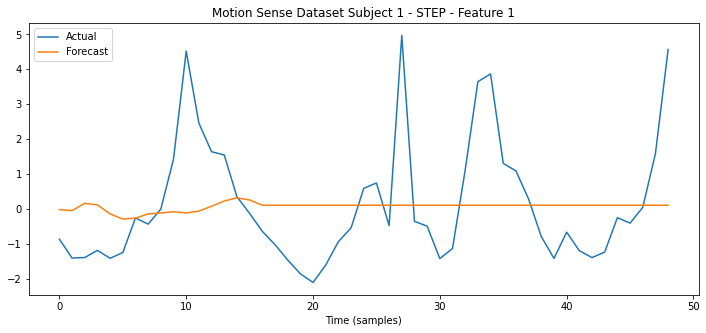

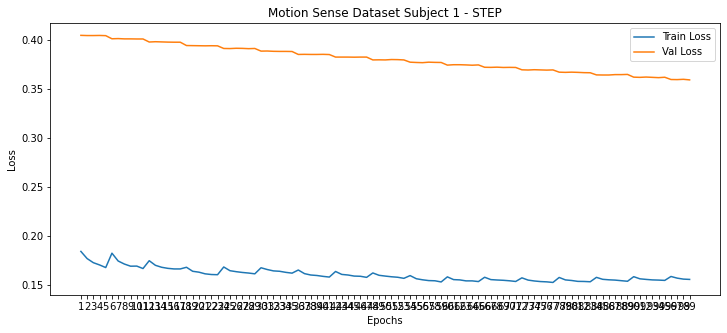

In [78]:
# Here is some code to generate your predicted time series figures (see GCN section below)
# Please use the same format, but replace <GCN> with <STEP> or <GraphWaveNet>
# Note: Subject 1 for MHealth, Subject 10 for MSense
# Upload figures to an image hosting website and embed the images in Markdown
import pandas as pd
ms_y= pd.read_csv('real.csv')
ms_y_pred = pd.read_csv('label.csv')
print(ms_y)
ms_y = ms_y.to_numpy()
ms_y_pred = ms_y_pred.to_numpy()
import matplotlib.pyplot as plt
from google.colab import files
plt.figure(figsize=(12, 5))
plt.plot(ms_y)
plt.plot(ms_y_pred)
plt.legend(["Actual", "Forecast"])
plt.xlabel('Time (samples)')
plt.title(r"Motion Sense Dataset Subject 1 - STEP - Feature 1" )
          #+ '\n' + \          
          #r"Naive MAE: %1.3f" %naive_mae + r" , " r"Model MAE: %1.3f" %model_mae, \
          #wrap=True, multialignment='center')
plt.savefig('msense_subject1_predictedfeature1_STEP.png', bbox_inches='tight')
files.download('msense_subject1_predictedfeature1_STEP.png') 
msfit = pd.read_csv('mSense.csv')
msfit = msfit.to_numpy()
# Example code to plot losses
plt.figure(figsize=(12, 5))
plt.plot(msfit[:,0])
plt.plot(msfit[:,1])
plt.legend(["Train Loss", "Val Loss"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(len(msfit[:,0])), 
           np.arange(1, len(msfit[:,0])+1))
plt.title(r"Motion Sense Dataset Subject 1 - STEP")
plt.savefig('msense_subject1_lossoverepochs_STEP.png', bbox_inches='tight')
files.download('msense_subject1_lossoverepochs_STEP.png') 